In [1]:
import datetime
import frads as fr
import matplotlib as mpl
import numpy as np
import os
import pyradiance as pr
import pywincalc
import subprocess as sp
from matplotlib.image import imread
import matplotlib.pyplot as plt
from typing import Tuple

In [34]:
total_frames = 180  # in 3fps for 1 min animation
spectrum = np.arange(390, 780, 20)[::-1]  # radiance is from red to blue

In [3]:
room = pr.Scene(
    sid="room",
    surfaces=["./Groups/exterior.rad", "./Groups/room.rad"],
    materials=["./Materials/material.rad", "./Materials/ec60.rad"],
)

In [4]:
room_ec01 = pr.Scene(
    sid="room",
    surfaces=["./Groups/exterior.rad", "./Groups/room.rad"],
    materials=["./Materials/material.rad", "./Materials/ec01.rad"],
)

In [5]:
# room with electric light
# no sun
room_elgt = pr.Scene(
    sid="room_elgt",
    surfaces=["./Groups/exterior.rad", "./Groups/room.rad", "./Objects/elec_light.rad"],
    materials=["./Materials/material.rad", "./Materials/ec60.rad"],
)

In [6]:
ssky = pr.genssky(
    dt=datetime.datetime(2024, 12, 21, 12),
    latitude=37,
    longitude=122,
    timezone=120,
    year=2024,
)
for prim in pr.parse_primitive(ssky.decode()):
    room.add_source(prim)

room.add_source(pr.Primitive("skyfunc", "glow", "skyglow", [], [1, 1, 1, 0]))
room.add_source(pr.Primitive("skyglow", "source", "skydome", [], [0, 0, 1, 180]))
room.add_source(pr.Primitive("skyglow", "source", "groundplane", [], [0, 0, -1, 180]))

In [7]:
for prim in pr.parse_primitive(ssky.decode()):
    room_ec01.add_source(prim)

room_ec01.add_source(pr.Primitive("skyfunc", "glow", "skyglow", [], [1, 1, 1, 0]))
room_ec01.add_source(pr.Primitive("skyglow", "source", "skydome", [], [0, 0, 1, 180]))
room_ec01.add_source(
    pr.Primitive("skyglow", "source", "groundplane", [], [0, 0, -1, 180])
)

In [8]:
view = pr.View(
    vtype="a", position=(70, 60, 49), direction=(1, -1, 0), horiz=180, vert=180
)
view_pt = (" ".join(str(item) for item in view.position + view.direction)).encode()

In [9]:
floor_primitives = fr.unpack_primitives("./Objects/floor.rad")
floor_prim = fr.parse_polygon(floor_primitives[0])
grid = fr.gen_grid(floor_prim, 28.875, 12)  # inches
grid = " ".join(" ".join(map(str, g)) for g in grid).encode()

In [10]:
tr_params = pr.SamplingParameters(ab=2, aa=0, ad=2048, lw=1e-5, dj=0.8, cs=20, co=True)

In [11]:
render_params = pr.SamplingParameters(
    ab=2, aa=0, ad=16, lw=1e-5, dj=0.8, cs=20, co=True
)

In [12]:
def interpolate_factor(
    range: Tuple[float, float], current_frame: int, frame_total: int
) -> float:
    """
    Calculate an interpolated factor using exponential interpolation.

    Parameters:
    range (tuple): A tuple of two numbers (start, end) representing the range to interpolate between.
    current_frame (int): The current frame number for which to calculate the interpolated value.
    frame_total (int): The total number of frames in the interpolation sequence.

    Returns:
    float: The interpolated factor for the current frame, normalized to a 0-1 range.
    """
    x1, x2 = 1, frame_total
    y1, y2 = range
    b = (y2 / y1) ** (1 / (x2 - x1))
    a = y1 / (b**x1)
    value = a * b**current_frame
    return value / y1

In [13]:
def get_ave_wpi(octree, sensors, params) -> float:
    """
    Get average workplane illuminance
    """
    wpi_dimming = pr.rtrace(
        sensors, octree, params=params, irradiance=True, header=False
    ).decode()
    wpi_dimming = [float(i) for i in wpi_dimming.split()]
    ave_wpi_dimming = sum(wpi_dimming) / len(wpi_dimming)
    return ave_wpi_dimming

In [18]:
spectral_transmittance_60 = np.loadtxt(
    "Materials/sageglass-sr20_7mm-lami-full-clear-60t.csv", skiprows=38, delimiter=","
)  # igsdb website orders the spectrum from blue to red
spectral_transmittance_60 = spectral_transmittance_60[
    np.isin(spectral_transmittance_60[:, 0], spectrum / 1000)
][:, 1]

spectral_transmittance_01 = np.loadtxt(
    "Materials/sageglass-sr20_7mm-lami-fully-tinted-1t.csv", skiprows=38, delimiter=","
)
spectral_transmittance_01 = spectral_transmittance_01[
    np.isin(spectral_transmittance_01[:, 0], spectrum / 1000)
][:, 1]

# reverse the spectrum order to be red to blue to match radiance convention
spectral_transmittance_60 = spectral_transmittance_60[::-1]
spectral_transmittance_01 = spectral_transmittance_01[::-1]

In [20]:
def get_tinted_factors(current_frame: int) -> np.array:
    """
    Get tinted factors for the current frame

    Parameters:
    current_frame (int): The current frame number for which to calculate the tinted factor.

    Returns:
    float: The tinted factor for the given frame number.
    """
    tinted_factor = []
    for st60, st01 in zip(spectral_transmittance_60, spectral_transmittance_01):
        tinted_factor.append(
            interpolate_factor((st60, st01), current_frame, total_frames)
        )
    return np.array(tinted_factor)

In [21]:
ird_tinted = (
    pr.rtrace(
        view_pt, room.octree, params=tr_params.args(), irradiance=True, header=False
    )
    .decode()
    .split()
)  # rtrace is always from red to blue
ird_dimming = (
    pr.rtrace(
        view_pt,
        room_elgt.octree,
        params=tr_params.args(),
        irradiance=True,
        header=False,
    )
    .decode()
    .split()
)
ird_tinted = list(map(float, ird_tinted))  # convert str to float
ird_dimming = list(map(float, ird_dimming))  # convert str to float


mlux_tinted = float(
    pr.rtrace(
        view_pt,
        room.octree,
        params=tr_params.args() + ["-pM"],
        irradiance=True,
        header=False,
    )
    .decode()
    .split()[0]
)
mlux_dimming = float(
    pr.rtrace(
        view_pt,
        room_elgt.octree,
        params=tr_params.args() + ["-pM"],
        irradiance=True,
        header=False,
    )
    .decode()
    .split()[0]
)
mlux_ec01 = float(
    pr.rtrace(
        view_pt,
        room_ec01.octree,
        params=tr_params.args() + ["-pM"],
        irradiance=True,
        header=False,
    )
    .decode()
    .split()[0]
)
ev_tinted = float(
    pr.rtrace(
        view_pt,
        room.octree,
        params=tr_params.args() + ["-pY"],
        irradiance=True,
        header=False,
    )
    .decode()
    .split()[0]
)
ev_dimming = float(
    pr.rtrace(
        view_pt,
        room_elgt.octree,
        params=tr_params.args() + ["-pY"],
        irradiance=True,
        header=False,
    )
    .decode()
    .split()[0]
)
ev_ec01 = float(
    pr.rtrace(
        view_pt,
        room_ec01.octree,
        params=tr_params.args() + ["-pY"],
        irradiance=True,
        header=False,
    )
    .decode()
    .split()[0]
)
wpi_tinted = get_ave_wpi(room.octree, grid, tr_params.args() + ["-pY"])
wpi_dimming = get_ave_wpi(room_elgt.octree, grid, tr_params.args() + ["-pY"])

/Users/tammieyu/LBNL/Projects/Electrospectral/.venv/lib/python3.11/site-packages/pyradiance/bin/oconv: warning - non-planar vertex for polygon "object_5.145"
/Users/tammieyu/LBNL/Projects/Electrospectral/.venv/lib/python3.11/site-packages/pyradiance/bin/oconv: warning - non-planar vertex for polygon "object_5.201"
/Users/tammieyu/LBNL/Projects/Electrospectral/.venv/lib/python3.11/site-packages/pyradiance/bin/oconv: warning - non-planar vertex for polygon "object_5.203"
/Users/tammieyu/LBNL/Projects/Electrospectral/.venv/lib/python3.11/site-packages/pyradiance/bin/oconv: warning - non-planar vertex for polygon "object_5.251"
/Users/tammieyu/LBNL/Projects/Electrospectral/.venv/lib/python3.11/site-packages/pyradiance/bin/oconv: warning - non-planar vertex for polygon "object_5.257"
/Users/tammieyu/LBNL/Projects/Electrospectral/.venv/lib/python3.11/site-packages/pyradiance/bin/oconv: warning - non-planar vertex for polygon "object_5.880"
/Users/tammieyu/LBNL/Projects/Electrospectral/.venv/

In [22]:
def get_dimming_factor(current_frame: int) -> float:
    """
    Get dimming factor for the current frame

    Parameters:
    current_frame (int): The current frame number for which to calculate the dimming factor.

    Returns:
    float: The dimming factor for the given frame number.
    """
    target_illum = 500
    tvis60 = 0.677
    tvis01 = 0.0108
    tvis_i = interpolate_factor((tvis60, tvis01), current_frame, total_frames)
    if wpi_tinted * tvis_i < target_illum:
        dimming_factor = min((target_illum - wpi_tinted * tvis_i) / wpi_dimming, 1)
    else:
        dimming_factor = 0
    return dimming_factor

In [23]:
os.makedirs("./Results", exist_ok=True)

In [24]:
img_tinted = pr.rtpict(
    view, room.octree, nproc=8, xres=3200, yres=3200, params=render_params.args()
)
with open("./Results/tinted.hsr", "wb") as wtr:
    wtr.write(img_tinted)

/Users/tammieyu/LBNL/Projects/Electrospectral/.venv/lib/python3.11/site-packages/pyradiance/bin/oconv: warning - non-planar vertex for polygon "object_5.145"
/Users/tammieyu/LBNL/Projects/Electrospectral/.venv/lib/python3.11/site-packages/pyradiance/bin/oconv: warning - non-planar vertex for polygon "object_5.201"
/Users/tammieyu/LBNL/Projects/Electrospectral/.venv/lib/python3.11/site-packages/pyradiance/bin/oconv: warning - non-planar vertex for polygon "object_5.203"
/Users/tammieyu/LBNL/Projects/Electrospectral/.venv/lib/python3.11/site-packages/pyradiance/bin/oconv: warning - non-planar vertex for polygon "object_5.251"
/Users/tammieyu/LBNL/Projects/Electrospectral/.venv/lib/python3.11/site-packages/pyradiance/bin/oconv: warning - non-planar vertex for polygon "object_5.257"
/Users/tammieyu/LBNL/Projects/Electrospectral/.venv/lib/python3.11/site-packages/pyradiance/bin/oconv: warning - non-planar vertex for polygon "object_5.880"
/Users/tammieyu/LBNL/Projects/Electrospectral/.venv/

In [25]:
img_dimming = pr.rtpict(
    view, room_elgt.octree, nproc=8, xres=3200, yres=3200, params=render_params.args()
)
with open("./Results/dimming.hsr", "wb") as wtr:
    wtr.write(img_dimming)

/Users/tammieyu/LBNL/Projects/Electrospectral/.venv/lib/python3.11/site-packages/pyradiance/bin/oconv: warning - non-planar vertex for polygon "object_5.145"
/Users/tammieyu/LBNL/Projects/Electrospectral/.venv/lib/python3.11/site-packages/pyradiance/bin/oconv: warning - non-planar vertex for polygon "object_5.201"
/Users/tammieyu/LBNL/Projects/Electrospectral/.venv/lib/python3.11/site-packages/pyradiance/bin/oconv: warning - non-planar vertex for polygon "object_5.203"
/Users/tammieyu/LBNL/Projects/Electrospectral/.venv/lib/python3.11/site-packages/pyradiance/bin/oconv: warning - non-planar vertex for polygon "object_5.251"
/Users/tammieyu/LBNL/Projects/Electrospectral/.venv/lib/python3.11/site-packages/pyradiance/bin/oconv: warning - non-planar vertex for polygon "object_5.257"
/Users/tammieyu/LBNL/Projects/Electrospectral/.venv/lib/python3.11/site-packages/pyradiance/bin/oconv: warning - non-planar vertex for polygon "object_5.880"
/Users/tammieyu/LBNL/Projects/Electrospectral/.venv/

In [26]:
def get_dgp(hdr: bytes) -> float:
    """
    Get DGP for the given hdr

    Parameters:
    hdr(bytes): The hdr to get the DGP for

    Returns:
    float: The DGP for the given hdr
    """
    evalglare_str = pr.evalglare(
        hdr, view=["-vta", "-vv", "180", "-vh", "180"]
    ).decode()

    dgp = round(float(evalglare_str.split(":")[1].split(" ")[1]), 2)
    return dgp

In [27]:
dgps = []
timesteps = []
for f in range(1, total_frames + 1):
    # get current time
    if f == 1:
        current_time = datetime.datetime(2024, 12, 21, 12)
    else:
        current_time += datetime.timedelta(seconds=1 / 3)
    timesteps.append(current_time.strftime("%H:%M:%S.%f")[:-5])
    # combined tinted hdr and dimming hdr
    # tinted_factor = get_tinted_factors(f)[
    #     ::-1
    # ]  # reverse the order becauae channel split from red to blue
    tinted_factor = get_tinted_factors(f)
    dimming_factor = get_dimming_factor(f)
    tinted = pr.RcombInput("./Results/tinted.hsr", scale=tinted_factor)
    dimming = pr.RcombInput("./Results/dimming.hsr", scale=[dimming_factor] * 20)
    combined_hdr = pr.rcomb([tinted, dimming], transform="RGB")
    # downsample hdr
    combined_ds_hdr = pr.pfilt(
        combined_hdr, xres="/3", yres="/3", gaussian_filter_radius=0.6, one_pass=True
    )
    with open("./Results/combined_ds.hdr", "wb") as file:
        file.write(combined_ds_hdr)

    # falsecolor hdr
    combined_ds_fc_hdr = pr.falsecolor(
        "./Results/combined_ds.hdr", contour="p", scale="1e6", decades=6, palette="tbo"
    )
    combined_ds_fc_ppm = pr.ra_ppm(combined_ds_fc_hdr)
    with open("./Results/combined_ds_fc.ppm", "wb") as file:
        file.write(combined_ds_fc_ppm)
    sp.run(f"magick ./Results/combined_ds_fc.ppm ./Results/fc_{f:03d}.png".split())
    # _, yres, _, xres = pr.getinfo(combined_ds_hdr, dimension_only=True).decode().split()
    # xres, yres = int(xres), int(yres)
    # img_data = pr.pvalue(combined_ds_hdr, header=False, outform='f', resstr=False)
    # img_array = np.frombuffer(img_data, dtype=np.single).reshape(xres, yres, 3)
    # luminance = img_array[:, :, 0] * 47.4 + img_array[:, :, 1] * 119.9 + img_array[:, :, 2] * 11.6
    # plt.imshow(luminance, cmap='turbo', norm=mpl.colors.LogNorm(vmax=1e6, vmin=1))
    # plt.colorbar()
    # plt.axis('off')
    # plt.savefig(f"./Results/fc_{f:03d}.png",bbox_inches='tight', dpi=500)
    # plt.close()

    # get dgp
    dgps.append(get_dgp(combined_ds_hdr))
    # add human visual tone mapping
    combined_ds_tm_hdr = pr.pcond("./Results/combined_ds.hdr", human=True)
    # convert to ppm
    combined_ds_tm_ppm = pr.ra_ppm(combined_ds_tm_hdr)
    with open(f"./Results/combined_ds_tm.ppm", "wb") as file:
        file.write(combined_ds_tm_ppm)
    # convert to png
    sp.run(f"magick ./Results/combined_ds_tm.ppm ./Results/{f:03d}.png".split())
    # remove temp files
    sp.run(
        f"rm ./Results/combined_ds_fc.ppm ./Results/combined_ds_tm.ppm ./Results/combined_ds.hdr".split()
    )

In [28]:
scene1 = pr.Scene("scene1")
sky_prims = pr.gendaylit(
    datetime.datetime(2024, 12, 21, 12),
    37,
    122,
    120,
    solar=True,
    dirnorm=800,
    diffhor=80,
).decode()
for prim in pr.parse_primitive(sky_prims):
    scene1.add_source(prim)
scene1.add_source(pr.Primitive("skyfunc", "glow", "skyglow", [], [1, 1, 1, 0]))
scene1.add_source(pr.Primitive("skyglow", "source", "skydome", [], [0, 0, 1, 180]))
scene1.add_source(pr.Primitive("skyglow", "source", "groundplane", [], [0, 0, -1, 180]))
incident_irradiance = float(
    pr.rtrace(
        b"0 -10 10 0 -1 0", scene1.octree, header=False, params=["-ab", "1", "-I"]
    )
    .decode()
    .split()[0]
)

In [29]:
inside_environment = pywincalc.Environment(
    air_temperature=294.15,
    pressure=101325.0,
    convection_coefficient=0.0,
    coefficient_model=pywincalc.BoundaryConditionsCoefficientModelType.CALCULATED_H,
    radiation_temperature=294.15,
    emissivity=1.0,
    air_speed=0.0,
    air_direction=pywincalc.AirHorizontalDirection.NONE,
    direct_solar_radiation=0,
)

outside_environment = pywincalc.Environment(
    air_temperature=285.15,
    pressure=101325.0,
    convection_coefficient=26.0,
    coefficient_model=pywincalc.BoundaryConditionsCoefficientModelType.CALCULATED_H,
    radiation_temperature=255.15,
    emissivity=1.0,
    air_speed=5.0,
    air_direction=pywincalc.AirHorizontalDirection.WINDWARD,
    direct_solar_radiation=incident_irradiance,
)

environmental_conditions = pywincalc.Environments(
    outside_environment, inside_environment
)

In [30]:
ec01 = pywincalc.parse_json_file("./Materials/igsdb_product_7405.json")
solid_layers = [ec01]
gs01 = pywincalc.GlazingSystem(
    solid_layers=solid_layers, environment=environmental_conditions
)
shgc_01 = gs01.shgc()

In [31]:
ec60 = pywincalc.parse_json_file("./Materials/igsdb_product_7406.json")
solid_layers = [ec60]
gs_60 = pywincalc.GlazingSystem(
    solid_layers=solid_layers, environment=environmental_conditions
)
shgc_60 = gs_60.shgc()

In [38]:
l_ev = []
l_mlux = []
l_thml = []

for f in np.arange(1, total_frames + 1):
    time = timesteps[f - 1]
    tinted_factor = get_tinted_factors(f)
    dimming_factor = get_dimming_factor(f)

    fig = plt.figure(figsize=(16, 9))

    gs = fig.add_gridspec(
        nrows=4,
        ncols=3,
        width_ratios=[3, 2, 1],
        height_ratios=[1, 1, 1, 1],
        #   left=0.05, right=0.95,
        #   top=0.95, bottom=0.05,
        #   wspace=0, hspace=0
    )

    fig.subplots_adjust(left=0.15)

    ax1 = fig.add_subplot(gs[:, 0])
    ax1.imshow(imread(f"./Results/{f:03d}.png"))
    ax1.set_anchor("N")
    ax1.axis("off")

    ax2 = fig.add_subplot(gs[:2, 1])
    ax2.imshow(imread(f"./Results/fc_{f:03d}.png"))
    ax2.axis("off")

    ax3 = fig.add_subplot(gs[2:, 1])
    ird_eye = []
    for it, tf, id in zip(ird_tinted, tinted_factor, ird_dimming):
        ird_eye.append(it * tf + id * dimming_factor)
    ax3.plot(spectrum, ird_eye, linewidth=3)
    ax3.set(xlabel="Wavelength (nm)", ylabel=r"Irradiance (W/m$^2$)", ylim=(0, 225))
    ax3.xaxis.set_major_locator(plt.MaxNLocator(5))
    ax3.yaxis.set_major_locator(plt.MaxNLocator(5))

    ax4 = fig.add_subplot(gs[0, 2])
    ev_tf = interpolate_factor((ev_tinted, ev_ec01), f, total_frames)
    ev = int(ev_tinted * ev_tf + ev_dimming * dimming_factor)
    l_ev.append(ev)
    ax4.plot(np.arange(1, f + 1) / 3, l_ev, linewidth=3)
    ax4.set(xlim=(0, 60), ylim=(0, 37500), ylabel="Ev (lux)")
    ax4.yaxis.get_major_formatter().set_powerlimits((0, 1))

    ax5 = fig.add_subplot(gs[1, 2])
    mlux_tf = interpolate_factor((mlux_tinted, mlux_ec01), f, total_frames)
    mlux = int(mlux_tinted * mlux_tf + mlux_dimming * dimming_factor)
    l_mlux.append(mlux)
    ax5.plot(np.arange(1, f + 1) / 3, l_mlux, linewidth=3)
    ax5.set(xlim=(0, 60), ylim=(0, 37500), ylabel="Mlux (EML)")
    # scientific notation
    ax5.yaxis.get_major_formatter().set_powerlimits((0, 1))

    ax6 = fig.add_subplot(gs[2, 2])
    ax6.plot(np.arange(1, f + 1) / 3, dgps[:f], linewidth=3)
    ax6.set(xlim=(0, 60), ylim=(0, 1.2), ylabel="DGP")

    ax7 = fig.add_subplot(gs[3, 2])
    sghc = interpolate_factor((shgc_60, shgc_01), f, total_frames)
    thml = int(sghc * incident_irradiance)
    l_thml.append(thml)
    ax7.plot(np.arange(1, f + 1) / 3, l_thml, linewidth=3)
    ax7.set(
        xlim=(0, 60), ylim=(0, 1000), xlabel="Time (s)", ylabel="Thermal load (w/m2)"
    )
    ax7.yaxis.get_major_formatter().set_powerlimits((0, 1))

    text = f"Time: {time}\nPhotopic illuminance: {ev} lux\nMelanopic illuminance: {mlux} EML\nDGP: {dgps[f-1]}\nThermal load: {thml} w/m2"
    ax1.text(
        0,
        -0.03,
        f"{text}",
        fontsize=20,
        transform=ax1.transAxes,
        ha="left",
        va="top",
        bbox=dict(facecolor="white", alpha=0.8, edgecolor="none"),
    )

    fig.savefig(f"./Results/compile_{f:03d}.png", dpi=500)

    plt.close(fig)

In [40]:
!ffmpeg -framerate 3 -i Results/compile_%03d.png -c:v libx264 -preset slow -crf 18 -vf "scale=800:800,format=yuv420p" final.mp4

ffmpeg version 7.0.2 Copyright (c) 2000-2024 the FFmpeg developers
  built with Apple clang version 15.0.0 (clang-1500.3.9.4)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.0.2_1 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex 

# extra data visualization


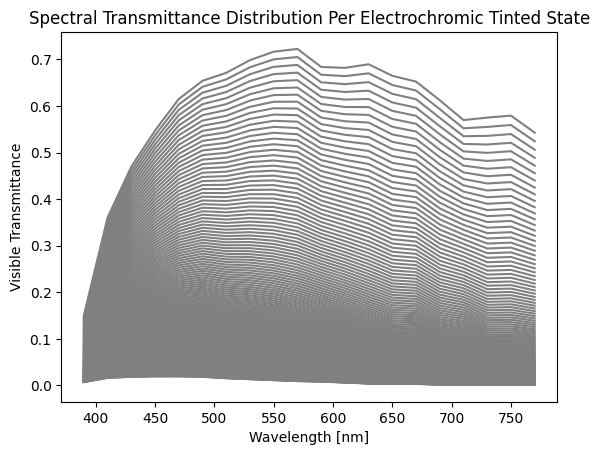

In [41]:
fig, ax = plt.subplots()
for i in np.arange(180):
    tf = get_tinted_factors(i)
    ax.plot(spectrum, tf * spectral_transmittance_60, color="0.5")
    ax.set_ylabel("Visible Transmittance")
    ax.set_xlabel("Wavelength [nm]")
    ax.set_title("Spectral Transmittance Distribution Per Electrochromic Tinted State")
fig.savefig("spectral_transmittance.png")

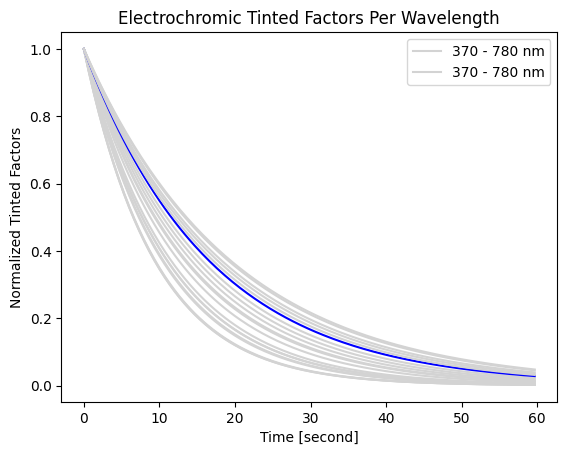

In [42]:
tfs = []
for f in np.arange(1, total_frames + 1):
    tint_factors = get_tinted_factors(f)
    tfs.append(tint_factors)
fig, ax = plt.subplots()
for n, sp in enumerate(spectrum):
    if sp == 490:
        color = "blue"
        label = "480-500 nm"
    else:
        color = "lightgray"
        label = "370 - 780 nm"
    ax.plot(np.arange(180) / 3, [tf[n] for tf in tfs], color=color, label=label)

label, legend = ax.get_legend_handles_labels()
ax.legend(label[5:7], legend[5:7])

ax.set_xlabel("Time [second]")
ax.set_ylabel("Normalized Tinted Factors")
ax.set_title("Electrochromic Tinted Factors Per Wavelength")

fig.savefig("tinted_factors.png")

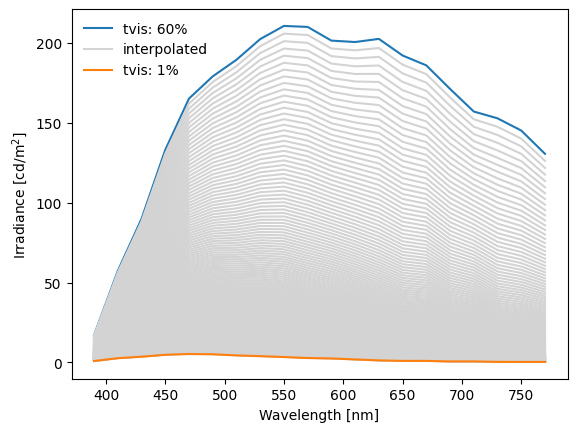

In [43]:
fig, ax = plt.subplots()
ax.plot(spectrum, ird_tinted, label="tvis: 60%")
for f in np.arange(2, total_frames + 1):
    if f == 180:
        color = "C1"
        label = "tvis: 1%"
    else:
        color = "lightgray"
        label = "interpolated"
    ax.plot(spectrum, ird_tinted * get_tinted_factors(f), color=color, label=label)
label, legend = ax.get_legend_handles_labels()
ax.legend(label[:1] + label[-2:], legend[:1] + legend[-2:], frameon=False)
ax.set(ylabel=r"Irradiance [cd/m$^2$]", xlabel="Wavelength [nm]")

fig.savefig("irradiance.png")

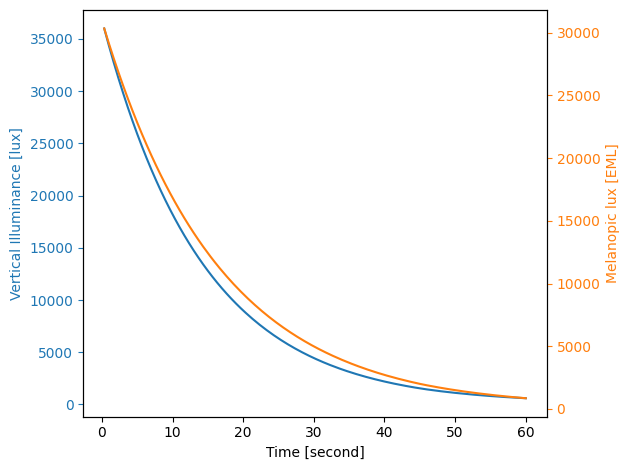

In [44]:
ev = []
mlux = []
fig, ax = plt.subplots()
for f in np.arange(1, total_frames + 1):
    dimming_factor = get_dimming_factor(f)
    ev_tf = interpolate_factor((ev_tinted, ev_ec01), f, total_frames)
    mlux_tf = interpolate_factor((mlux_tinted, mlux_ec01), f, total_frames)
    ev.append(int(ev_tinted * ev_tf + ev_dimming * dimming_factor))
    mlux.append(int(mlux_tinted * mlux_tf + mlux_dimming * dimming_factor))
ax.plot(np.arange(1, total_frames + 1) / 3, ev, label="ev")
ax1 = ax.twinx()
ax1.plot(np.arange(1, total_frames + 1) / 3, mlux, label="mlux", color="C1")
# ax.plot(np.arange(1, total_frames+1), [500]*total_frames, linestyle="dashed", color="lightgray", label = r"target wpi = 500 lux$")

ax.set_xlabel(xlabel="Time [second]")
ax.set_ylabel(ylabel="Vertical Illuminance [lux]", color="C0")
ax1.set_ylabel(ylabel="Melanopic lux [EML]", color="C1")
ax.tick_params(axis="y", colors="C0")
ax1.tick_params(axis="y", colors="C1")

fig.tight_layout()
fig.savefig("ev_mlux.png")

In [ ]:
# wpi_wo_lgt = []
# wpi_lgt = []
# dimming_factors= []
# target_illum = 500
# tvis60 = 0.677
# tvis01 = 0.0108

# fig, ax = plt.subplots()
# for f in np.arange(1, total_frames+1):
#     dimming_factor = get_dimming_factor(f)
#     dimming_factors.append(dimming_factor)
#     tvis_i = interpolate_factor((tvis60, tvis01), f, total_frames)
#     wpi_wo_lgt.append(wpi_tinted * tvis_i)
#     wpi_lgt.append(wpi_tinted * tvis_i + dimming_factor * wpi_dimming)
# ax.plot([500]*60, linestyle="dashed", color="lightgray", label = r"target wpi = 500 lux$")
# ax.plot(np.arange(1, total_frames+1)/3, wpi_wo_lgt, label="without electric light")
# ax.plot(np.arange(1, total_frames+1)/3, wpi_lgt, label="with electric light", linestyle="dashed")

# ax1 = ax.twinx()
# ax1.plot(np.arange(1, total_frames+1)/3, dimming_factors, label="dimming factor", color="C1")